In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!cd drive

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/NST"

base.ipynb  deneme.ipynb  main.py    newww.ipynb  nst.ipynb  targets
contents    dnm.py	  movie.gif  nst_1.ipynb  styles


In [ ]:
!pip3 install -q keras

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19, vgg16, resnet50
import os
import time

In [3]:
root_path = "/content/drive/MyDrive/Colab Notebooks/NST/" # colab için:
#root_path = ""
content = "content_1" # contents klasöründe bulunan görüntünün adı
style = "style_5" # styles klasöründe bulunan görüntünün adı
opt_method = "Adam" # Adam, RMSprop, SGD
vgg_model = "VGG19" # VGG16, VGG19, ResNet50
iterations = 3000

# content, style, toplam değişim için güncelleme parametreleri belirliyoruz.
total_variation_weight = 1e-6
style_weight = total_variation_weight
content_weight = 2.5e-6

# content ve style görüntüleri için dosya yolu belirtiyoruz.
content_img_path = root_path + "contents/" + content + ".jpeg"
style_img_path = root_path + "styles/" + style + ".jpeg"

# content ve style görüntülerimizin boyutlarını tutuyoruz.
width, height = keras.preprocessing.image.load_img(content_img_path).size
width2, height2 = keras.preprocessing.image.load_img(style_img_path).size

# target görüntümüz için boyut belirliyoruz.
img_rows = 500
img_cols = int(width * img_rows / height) 

In [4]:
def show_images(content, style):
    content = plt.imread(content)
    style = plt.imread(style)
    _, ax = plt.subplots(1, 2, figsize=(18, 6))

    text_color = "black"
    text_size = "16"
    
    ax[0].imshow(content)
    ax[0].set_title("İçerik Görüntüsü", color=text_color, size=text_size)
    ax[1].imshow(style)
    ax[1].set_title("Stil Görüntüsü", color=text_color, size=text_size)

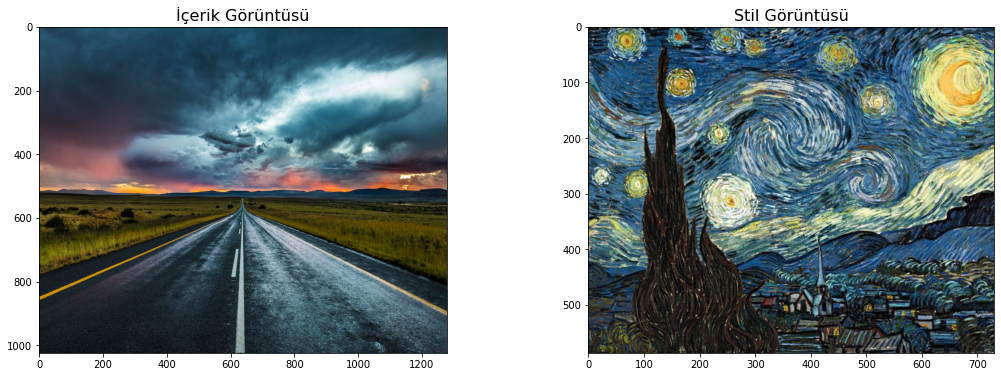

In [5]:
show_images(content_img_path, style_img_path)

In [6]:
# görüntülerimizi modelimize uygun bir tensör haline çeviriyoruz.
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_rows, img_cols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    if vgg_model == "VGG16":
      img = vgg16.preprocess_input(img)
    elif vgg_model == "VGG19":
      img = vgg19.preprocess_input(img)
    elif vgg_model == "ResNet50":
      img = resnet50.preprocess_input(img)
    else: 
      print("CNN modelini kontrol edin.")
    return tf.convert_to_tensor(img)

# yaptığımız önişlemlerden geri çeviriyoruz.
def deprocess_image(x):
    x = x.reshape((img_rows, img_cols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [7]:
# korelasyon hesabı yapabilmek için ihtiyaç duyduğumuz matris.
def gram_matrix(x): 
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram 

# stil kaybını hesaplayalım...
def style_loss(style, target):
    S = gram_matrix(style)
    T = gram_matrix(target)
    channels = 3
    size = img_rows * img_cols
    return tf.reduce_sum(tf.square(S - T)) / (4.0 * (channels ** 2) * (size ** 2))

# içerik kaybını hesaplayalım...
def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))

# toplam değişim kaybını hesaplayalım...
def total_variation_loss(x):
    a = tf.square( x[:, : img_rows - 1, : img_cols - 1, :] - x[:, 1:, : img_cols - 1, :] )
    b = tf.square( x[:, : img_rows - 1, : img_cols - 1, :] - x[:, : img_rows - 1, 1:, :] )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [8]:
# CNN modeli belirliyoruz.
if vgg_model == "VGG16":
  model = vgg16.VGG16(weights="imagenet", include_top=False)
elif vgg_model == "VGG19": 
  model = vgg19.VGG19(weights="imagenet", include_top=False)
elif vgg_model == "ResNet50":
  model = resnet50.ResNet50(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)
#model.summary()

80142336/80134624 [==============================] - 1s 0us/step


In [9]:
if vgg_model == "VGG16" or vgg_model == "VGG19":
  style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
  ]
  content_layer_name = "block5_conv2"
elif vgg_model == "ResNet50":
  style_layer_names = [
    "conv2_block2_1_bn",
    "conv3_block1_0_bn",
    "conv3_block1_0_conv",
    "conv4_block6_2_conv",
  ]
  content_layer_name = "conv5_block1_2_conv"
elif vgg_model == "ResNet101":
  style_layer_names = [
    "conv2_block1_1_conv",
    "conv3_block1_1_conv",
    "conv4_block1_1_conv",
    "conv5_block1_1_conv",
  ]
  content_layer_name = "conv5_block3_1_conv"
elif vgg_model == "ResNet152":
  style_layer_names = [
    "conv2_block1_1_conv",
    "conv3_block1_1_conv",
    "conv4_block1_1_conv",
    "conv5_block1_1_conv",
  ]
  content_layer_name = "conv5_block3_1_conv"
elif vgg_model == "Xception":
  style_layer_names = [
    "block1_conv1_bn",
    "block1_conv2_bn",
    "batch_normalization_1",
    "batch_normalization_2",
    "batch_normalization_3",

  ]
  content_layer_name = "block1_conv2"
else:
  print("Network u kontrol edin.")

print(style_layer_names)
print(content_layer_name)

# toplam kaybı hesaplayalım...
def compute_loss(target_image, content_image, style_image):
    input_tensor = tf.concat(
        [content_image, style_image, target_image], axis=0
    )

    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    content_image_features = layer_features[0, :, :, :]
    target_image_features = layer_features[2, :, :, :]

    # içerik kayıp değeri ekleniyor.
    loss = loss + content_weight * content_loss(
        content_image_features, target_image_features
    )

    # stil kayıp değerleri ekleniyor.
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_image_features = layer_features[1, :, :, :]
        target_image_features = layer_features[2, :, :, :]

        sl = style_loss(style_image_features, target_image_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # toplam değişim kayıpları ekleniyor.
    loss += total_variation_weight * total_variation_loss(target_image)
    return loss

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
block5_conv2


In [10]:
@tf.function
def compute_loss_and_grads(target_image, content_image, style_image):
    with tf.GradientTape() as tape: #otomatik türev ile hatayı minimize etmeye çalışıyoruz.
        loss = compute_loss(target_image, content_image, style_image)
    grads = tape.gradient(loss, target_image)
    return loss, grads

In [13]:
# kullanılacak olan optimizer yöntemini kerastan çekiyoruz.
def set_optimizer(opt):
  if opt == "Adam":
    optimizer = keras.optimizers.Adam(
      keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=0.01, decay_steps=100, decay_rate=0.96
      )
    )
  elif opt == "RMSprop":
    optimizer = keras.optimizers.RMSprop(
      keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=0.01, decay_steps=100, decay_rate=0.96
      )
    )
  elif opt == "SGD":
    optimizer = keras.optimizers.SGD(
      keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
      )
    )
  else: 
    print("Optimizasyon yönteminizi kontrol edin.")
  return optimizer

# hedef görüntüsünün yer alacağı dizin belirleniyor.
def set_target_path(model, opt):
  model_path = root_path + "targets" + "/" + model
  opt_path = model_path + "/" + opt
  if os.path.isdir(model_path) == True:
    if os.path.isdir(opt_path) == True:
      target_path = opt_path + "/" + content + "_" + style
    else:
      os.mkdir(opt_path)
      target_path = opt_path + "/" + content + "_" + style
  else:
    os.mkdir(model_path)
    os.mkdir(opt_path)
    target_path = opt_path + "/" + content + "_" + style
  return target_path

Iteration 100: loss=44361.55
Iteration 200: loss=37305.53
Iteration 300: loss=31238.50
Iteration 400: loss=26271.91
Iteration 500: loss=22402.23
Iteration 600: loss=19384.33
Iteration 700: loss=16948.37
Iteration 800: loss=14938.91
Iteration 900: loss=13266.67
Iteration 1000: loss=11876.27
Iteration 1100: loss=10718.83
Iteration 1200: loss=9753.40
Iteration 1300: loss=8943.82
Iteration 1400: loss=8260.27
Iteration 1500: loss=7679.32
Iteration 1600: loss=7181.36
Iteration 1700: loss=6750.44
Iteration 1800: loss=6375.51
Iteration 1900: loss=6047.27
Iteration 2000: loss=5758.09
Iteration 2100: loss=5501.79
Iteration 2200: loss=5274.03
Iteration 2300: loss=5070.46
Iteration 2400: loss=4887.68
Iteration 2500: loss=4723.52
Iteration 2600: loss=4575.67
Iteration 2700: loss=4441.98
Iteration 2800: loss=4320.69
Iteration 2900: loss=4210.47
Iteration 3000: loss=4110.15
Total time: 2460.6


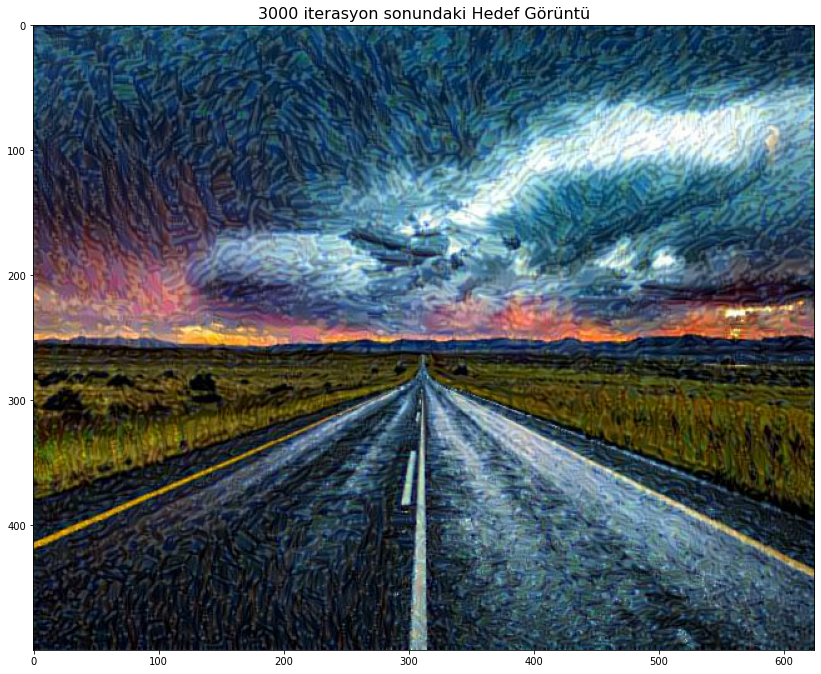

In [14]:
# görüntüleri belirliyoruz.
content_image = preprocess_image(content_img_path)
style_image = preprocess_image(style_img_path)
target_image = tf.Variable(preprocess_image(content_img_path))

start = time.time()
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        target_image, content_image, style_image
    )
    set_optimizer(opt_method).apply_gradients([(grads, target_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(target_image.numpy())
        target = set_target_path(vgg_model, opt_method) + "_at_iteration_%d.jpeg" % i
        end = time.time()
        keras.preprocessing.image.save_img(target, img)
        if i == iterations:
          print("Total time: {:.1f}".format(end-start))
          target_img = plt.imread(target)
          _, t = plt.subplots(1, figsize=(14, 14))
          t.imshow(target_img)
          t.set_title(str(iterations) + " iterasyon sonundaki Hedef Görüntü", color="black", size=16)